# Statistical Analysis of GA Hyperparameter Experiments

This notebook analyzes results from multiple GA runs with different hyperparameters to identify which settings work best.

In [44]:
# ============================================================
# Configuration - Set these parameters
# ============================================================

# Which runner configuration to analyze
runner_name = 'Baseline'  # e.g., 'Baseline', 'PopSize+Generations', 'CostWeights', etc.

# Was fast_mode used?
fast_mode = False  # Set to True if analyzing fast_mode results

# Results directory
results_dir = '../../results/many_ga/abbr/'

# Generations to analyze
generations_to_analyze = [100,200,300,400,499] if not fast_mode else [2,3,4,5]

In [45]:
import sys
sys.path.append('../core')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import dill
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

def compute_pvalue(df, modifier, outcome_var='cost_final'):
    """
    Compute p-value for association between modifier and outcome using linear regression.
    
    This uses ordinary least squares regression and returns the p-value for the slope coefficient.
    For binary variables, this is equivalent to a t-test.
    
    Returns: (p_value, test_name)
    """
    df_clean = df[[modifier, outcome_var]].dropna()
    
    # Need at least 3 samples for meaningful statistics
    if len(df_clean) < 3:
        return np.nan, 'insufficient_data'
    
    # Check if there's any variation in the modifier
    if df_clean[modifier].nunique() <= 1:
        return np.nan, 'no_variation'
    
    try:
        # Convert to numeric if boolean
        X = pd.to_numeric(df_clean[modifier], errors='coerce')
        y = df_clean[outcome_var]
        
        # Remove any NaN that resulted from conversion
        mask = ~(X.isna() | y.isna())
        X = X[mask]
        y = y[mask]
        
        if len(X) < 3:
            return np.nan, 'insufficient_data'
        
        # Perform linear regression using scipy
        slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
        
        return p_value, 'LinReg'
        
    except Exception as e:
        return np.nan, 'error'

def format_pvalue(p_val):
    """Format p-value for display"""
    if np.isnan(p_val):
        return 'p=N/A'
    elif p_val < 0.001:
        return 'p<0.001***'
    elif p_val < 0.01:
        return f'p={p_val:.3f}**'
    elif p_val < 0.05:
        return f'p={p_val:.3f}*'
    else:
        return f'p={p_val:.3f}'

def plot_modifier_vs_outcome(ax, df, modifier, outcome_var, show_pval=True):
    """
    Plot modifier vs outcome variable (cost or runtime).
    Uses box plot for binary variables, scatter plot otherwise.
    
    Parameters:
    -----------
    ax : matplotlib axis
    df : DataFrame
    modifier : str - column name of modifier/hyperparameter
    outcome_var : str - column name of outcome (e.g., 'cost_final', 'runtime')
    show_pval : bool - whether to show p-value in title
    
    Returns:
    --------
    p_val : float - p-value for the association
    """
    is_numeric = pd.api.types.is_numeric_dtype(df[modifier])
    is_boolean = df[modifier].dtype == bool or set(df[modifier].unique()).issubset({True, False, np.nan})
    n_unique = df[modifier].nunique()
    
    df_plot = df[[modifier, outcome_var]].dropna()
    
    if len(df_plot) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return np.nan
    
    # Compute p-value using linear regression
    p_val, test_name = compute_pvalue(df, modifier, outcome_var)
    
    # Use box plot only for binary variables
    if n_unique == 2:
        sns.boxplot(data=df_plot, x=modifier, y=outcome_var, ax=ax)
        ax.set_xlabel(modifier, fontsize=9)
    else:
        # Use scatter plot for everything else
        ax.scatter(df_plot[modifier], df_plot[outcome_var], alpha=0.6, s=50)
        
        # Add trend line if numeric with >2 unique values
        if is_numeric and len(df_plot) > 1 and n_unique > 2:
            z = np.polyfit(df_plot[modifier], df_plot[outcome_var], 1)
            p = np.poly1d(z)
            x_line = np.linspace(df_plot[modifier].min(), df_plot[modifier].max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel(modifier, fontsize=9)
    
    ax.set_ylabel(outcome_var.replace('_', ' ').title(), fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add p-value to title if requested
    if show_pval:
        title = f'{format_pvalue(p_val)}'
        ax.set_title(title, fontsize=9)
    
    return p_val


def analyze_outcome_vs_hyperparameters(df, outcome_var, outcome_name, modifier_cols):
    """
    Unified function to analyze how hyperparameters affect an outcome (cost, score, or runtime).
    
    Parameters:
    -----------
    df : DataFrame containing results
    outcome_var : str - column name of outcome variable (e.g., 'cost_final', 'score_final', 'runtime')
    outcome_name : str - human-readable name for the outcome (e.g., 'Score', 'Runtime')
    modifier_cols : list - hyperparameter column names to analyze
    """
    if len(df) == 0 or outcome_var not in df.columns or df[outcome_var].isna().all():
        print(f"No {outcome_name.lower()} data available for analysis")
        return
    
    # Filter out modifiers with no variation
    modifier_cols = [col for col in modifier_cols if df[col].nunique() > 1]
    
    if len(modifier_cols) == 0:
        print(f"No hyperparameters with variation to analyze against {outcome_name.lower()}")
        return
    
    print(f"\nAnalyzing {len(modifier_cols)} hyperparameters vs {outcome_name}...\n")
    
    # Create grid of plots
    n_cols = min(3, len(modifier_cols))
    n_rows = (len(modifier_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)
    
    fig.suptitle(f'{outcome_name} vs Hyperparameters', fontsize=16, fontweight='bold')
    
    for idx, modifier in enumerate(modifier_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Use helper function to create plot
        p_val = plot_modifier_vs_outcome(ax, df, modifier, outcome_var, show_pval=True)
        
        # Update title to include modifier name
        current_title = ax.get_title()
        ax.set_title(f'{modifier}\n{current_title}', fontsize=9)
    
    # Hide empty subplots
    for idx in range(len(modifier_cols), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print(f"HYPERPARAMETER ASSOCIATIONS WITH {outcome_name.upper()}")
    print("="*70)
    
    for modifier in modifier_cols:
        is_numeric = pd.api.types.is_numeric_dtype(df[modifier])
        is_boolean = df[modifier].dtype == bool or set(df[modifier].unique()).issubset({True, False, np.nan})
        n_unique = df[modifier].nunique()
        
        if is_numeric and not is_boolean and n_unique > 2:
            corr = df[[modifier, outcome_var]].corr().iloc[0, 1]
            p_val, test_name = compute_pvalue(df, modifier, outcome_var)
            print(f"\n{modifier}:")
            print(f"  Correlation: {corr:+.3f} ({format_pvalue(p_val)})")
        elif n_unique >= 2:
            p_val, test_name = compute_pvalue(df, modifier, outcome_var)
            print(f"\n{modifier}:")
            print(f"  Association: {format_pvalue(p_val)} [{test_name}]")

print("Imports and helper functions complete")

Imports and helper functions complete


## Load Results

In [46]:
# Find all result files matching the runner name
pattern = f"{results_dir}/{runner_name}_*_*.pkl"
result_files = sorted(glob.glob(pattern))
#result_files = [r for r in result_files if '_3' in r]

print(f"Found {len(result_files)} result files for '{runner_name}'")
print(f"Pattern: {pattern}")

if len(result_files) == 0:
    print("\nNo files found! Available files:")
    all_files = glob.glob(f"{results_dir}/*.pkl")
    for f in all_files[:10]:
        print(f"  {Path(f).name}")
    if len(all_files) > 10:
        print(f"  ... and {len(all_files)-10} more")

Found 27 result files for 'Baseline'
Pattern: ../../results/many_ga/abbr//Baseline_*_*.pkl


In [47]:
## Load all results and extract data
data_records = []
skipped_fast = 0
skipped_slow = 0

for filepath in result_files:
    try:
        with open(filepath, 'rb') as f:
            r = dill.load(f)
        
        # Skip if exception occurred
        if r.exception is not None:
            print(f"Skipping {Path(filepath).name} - exception occurred")
            continue
        
        # Skip if no results
        if r.best_costs is None:
            print(f"Skipping {Path(filepath).name} - no best_costs")
            continue

        # Filter by fast_mode based on number of generations
        n_gens = r.best_costs.shape[0]
        is_fast_mode_result = 'fast' in filepath  # Fast mode typically has fewer generations
        if fast_mode and not is_fast_mode_result:
            skipped_slow += 1
            continue  # Skip slow mode results when analyzing fast mode
        if not fast_mode and is_fast_mode_result:
            skipped_fast += 1
            continue  # Skip fast mode results when analyzing slow mode

        # Extract basic info
        record = {
            'seed': r.seed,
            'runtime': r.runtime_seconds if hasattr(r, 'runtime_seconds') else np.nan,
            'filename': Path(filepath).name,
            'n_generations': n_gens
        }
        
        # Extract modifier values (hyperparameters)
        for key, value in r.modifier_values.items():
            if key != 'seed':
                record[key] = value
        
        # Extract costs at different generations
        # r.best_costs shape: (n_generations, n_configs)
        n_configs = r.best_costs.shape[1]
        for gen in generations_to_analyze:
            if gen < n_gens:
                # Average cost across all configs
                record[f'cost_gen_{gen}'] = np.mean(r.best_costs[gen, :])
                # Also store per-config costs
                for i_config in range(n_configs):
                    record[f'cost_gen_{gen}_config_{i_config}'] = r.best_costs[gen, i_config]
        
        # Final cost
        record['cost_final'] = np.mean(r.best_costs[-1, :])
        record['cost_final_std'] = np.std(r.best_costs[-1, :])

        # Extract scores from champions if available (pack_ga2 structure)
        if hasattr(r.result_ga, 'ga') and hasattr(r.result_ga.ga, 'champions') and r.result_ga.ga.champions is not None:
            champions = r.result_ga.ga.champions
            if len(champions) > 0:
                # Extract scores from champions (each champion has fitness tuple)
                scores = []
                for champion in champions:
                    if hasattr(champion, 'fitness') and champion.fitness is not None and len(champion.fitness) > 0:
                        # Fitness is (N_solutions, N_components) - take first solution
                        champion_fitness = champion.fitness[0]
                        # For fixed_h mode, fitness[0] is h value, fitness[1] is cost
                        # For non-fixed_h mode, fitness[0] is cost
                        # Score = area per tree = (h^2 / N_trees) or extract from fitness
                        if hasattr(champion.phenotype, 'use_fixed_h') and champion.phenotype.use_fixed_h:
                            h_val = float(champion_fitness[0])
                        else:
                            # Estimate h from phenotype
                            h_val = float(champion.phenotype.h[0, 0].get())
                        
                        # Calculate score as h^2 / N_trees
                        n_trees = champion.phenotype.N_trees
                        score = (h_val ** 2) / n_trees
                        scores.append(score)
                
                # Store average and std of scores
                if len(scores) > 0:
                    record['score_final'] = np.mean(scores)
                    record['score_final_std'] = np.std(scores) if len(scores) > 1 else 0.0
                    # Store individual scores
                    for i_config, score in enumerate(scores):
                        record[f'score_config_{i_config}'] = score
                else:
                    record['score_final'] = np.nan
                    record['score_final_std'] = np.nan
            else:
                record['score_final'] = np.nan
                record['score_final_std'] = np.nan
        else:
            record['score_final'] = np.nan
            record['score_final_std'] = np.nan

        data_records.append(record)
        
    except Exception as e:
        print(f"Error loading {Path(filepath).name}: {e}")

# Create DataFrame
df = pd.DataFrame(data_records)

print(f"\nSuccessfully loaded {len(df)} runs")
if skipped_fast > 0:
    print(f"Skipped {skipped_fast} fast-mode runs (analyzing slow mode)")
if skipped_slow > 0:
    print(f"Skipped {skipped_slow} slow-mode runs (analyzing fast mode)")
print(f"Columns: {list(df.columns)}")
print(f"\nDataFrame shape: {df.shape}")
if len(df) > 0:
    print(f"Generation range: {df['n_generations'].min()}-{df['n_generations'].max()}")
    
    # Show score statistics if available
    if 'score_final' in df.columns and not df['score_final'].isna().all():
        print(f"\nScore statistics (legalized area per tree):")
        print(f"  Mean: {df['score_final'].mean():.6f}")
        print(f"  Median: {df['score_final'].median():.6f}")
        print(f"  Min: {df['score_final'].min():.6f}")
        print(f"  Max: {df['score_final'].max():.6f}")
        print(f"  Std: {df['score_final'].std():.6f}")
#df = df[ ((df['seed']>2800) & (df['use_fixed_h_for_size_setup'] & df['genotype_at']==1)) & (~df['reduce_h_per_individual'] & df['alter_diversity']==1)]
df
df=df[df['seed']>5000]
#& (~df['reduce_h_per_individual'] & df['alter_diversity']==1)
df


Successfully loaded 27 runs
Columns: ['seed', 'runtime', 'filename', 'n_generations', 'crystal_offset', 'cost_gen_100', 'cost_gen_100_config_0', 'cost_gen_200', 'cost_gen_200_config_0', 'cost_gen_300', 'cost_gen_300_config_0', 'cost_gen_400', 'cost_gen_400_config_0', 'cost_gen_499', 'cost_gen_499_config_0', 'cost_final', 'cost_final_std', 'score_final', 'score_final_std', 'score_config_0', 'N_trees_to_do']

DataFrame shape: (27, 21)
Generation range: 63-501

Score statistics (legalized area per tree):
  Mean: 0.345661
  Median: 0.345513
  Min: 0.339690
  Max: 0.356584
  Std: 0.004647


,seed,runtime,filename,n_generations,crystal_offset,cost_gen_100,cost_gen_100_config_0,cost_gen_200,cost_gen_200_config_0,cost_gen_300,...,cost_gen_400,cost_gen_400_config_0,cost_gen_499,cost_gen_499_config_0,cost_final,cost_final_std,score_final,score_final_std,score_config_0,N_trees_to_do
25,6000,1137.119133,Baseline_6000_54416cb0_a.pkl,201,NaN,0.351016,0.351016,0.347279,0.347279,NaN,...,NaN,NaN,NaN,NaN,0.347279,0.0,0.347879,0.0,0.347879,76.0
26,6001,1137.387365,Baseline_6001_54416cb0_a.pkl,201,NaN,0.347652,0.347652,0.346162,0.346162,NaN,...,NaN,NaN,NaN,NaN,0.346162,0.0,0.346812,0.0,0.346812,76.0


## Summary Statistics

In [48]:
if len(df) > 0:
    print("=" * 70)
    print("OVERALL SUMMARY")
    print("=" * 70)
    print(f"\nTotal runs: {len(df)}")
    print(f"\nRuntime statistics:")
    if 'runtime' in df.columns and not df['runtime'].isna().all():
        print(f"  Mean: {df['runtime'].mean():.1f}s")
        print(f"  Median: {df['runtime'].median():.1f}s")
        print(f"  Min: {df['runtime'].min():.1f}s")
        print(f"  Max: {df['runtime'].max():.1f}s")
    else:
        print("  No runtime data available")
    
    print(f"\nFinal cost statistics:")
    print(f"  Mean: {df['cost_final'].mean():.6f}")
    print(f"  Median: {df['cost_final'].median():.6f}")
    print(f"  Min: {df['cost_final'].min():.6f}")
    print(f"  Max: {df['cost_final'].max():.6f}")
    print(f"  Std: {df['cost_final'].std():.6f}")
    
    # Scores statistics if available
    if 'score_final' in df.columns and not df['score_final'].isna().all():
        print(f"\nFinal score statistics (legalized area per tree):")
        print(f"  Mean: {df['score_final'].mean():.6f}")
        print(f"  Median: {df['score_final'].median():.6f}")
        print(f"  Min: {df['score_final'].min():.6f}")
        print(f"  Max: {df['score_final'].max():.6f}")
        print(f"  Std: {df['score_final'].std():.6f}")
    
    print(f"\nBest 5 runs (by final cost):")
    best_runs = df.nsmallest(5, 'cost_final')
    for idx, row in best_runs.iterrows():
        score_str = f", score={row.get('score_final', np.nan):.6f}" if 'score_final' in row and not pd.isna(row.get('score_final')) else ""
        print(f"  Seed {row['seed']:3d}: cost={row['cost_final']:.6f}{score_str}, runtime={row.get('runtime', np.nan):.1f}s")
    
    print(f"\nWorst 5 runs (by final cost):")
    worst_runs = df.nlargest(5, 'cost_final')
    for idx, row in worst_runs.iterrows():
        score_str = f", score={row.get('score_final', np.nan):.6f}" if 'score_final' in row and not pd.isna(row.get('score_final')) else ""
        print(f"  Seed {row['seed']:3d}: cost={row['cost_final']:.6f}{score_str}, runtime={row.get('runtime', np.nan):.1f}s")
    
    # Best runs by score if available
    if 'score_final' in df.columns and not df['score_final'].isna().all():
        print(f"\nBest 5 runs (by final score):")
        best_score_runs = df.nsmallest(5, 'score_final')
        for idx, row in best_score_runs.iterrows():
            print(f"  Seed {row['seed']:3d}: score={row['score_final']:.6f}, cost={row['cost_final']:.6f}, runtime={row.get('runtime', np.nan):.1f}s")
    
    # Identify modifier columns (hyperparameters)
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 'score_final', 'score_final_std'] and 
                     not col.startswith('cost_gen_') and not col.startswith('score_trees_')]
    
    if len(modifier_cols) > 0:
        print(f"\nHyperparameters varied: {', '.join(modifier_cols)}")
else:
    print("No data loaded!")

OVERALL SUMMARY

Total runs: 2

Runtime statistics:
  Mean: 1137.3s
  Median: 1137.3s
  Min: 1137.1s
  Max: 1137.4s

Final cost statistics:
  Mean: 0.346721
  Median: 0.346721
  Min: 0.346162
  Max: 0.347279
  Std: 0.000790

Final score statistics (legalized area per tree):
  Mean: 0.347345
  Median: 0.347345
  Min: 0.346812
  Max: 0.347879
  Std: 0.000755

Best 5 runs (by final cost):
  Seed 6001: cost=0.346162, score=0.346812, runtime=1137.4s
  Seed 6000: cost=0.347279, score=0.347879, runtime=1137.1s

Worst 5 runs (by final cost):
  Seed 6000: cost=0.347279, score=0.347879, runtime=1137.1s
  Seed 6001: cost=0.346162, score=0.346812, runtime=1137.4s

Best 5 runs (by final score):
  Seed 6001: score=0.346812, cost=0.346162, runtime=1137.4s
  Seed 6000: score=0.347879, cost=0.347279, runtime=1137.1s

Hyperparameters varied: n_generations, crystal_offset, score_config_0, N_trees_to_do


## Convergence Analysis

Plot costs at different generations to see convergence patterns.

In [49]:
# if len(df) > 0:
#     # Get cost columns for the specified generations
#     cost_cols = [f'cost_gen_{gen}' for gen in generations_to_analyze if f'cost_gen_{gen}' in df.columns]
    
#     if len(cost_cols) > 0:
#         fig, axes = plt.subplots(1, len(cost_cols), figsize=(5*len(cost_cols), 5))
#         if len(cost_cols) == 1:
#             axes = [axes]
        
#         for ax, col in zip(axes, cost_cols):
#             gen = int(col.split('_')[-1])
#             ax.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
#             ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.5f}')
#             ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.5f}')
#             ax.set_xlabel('Cost')
#             ax.set_ylabel('Count')
#             ax.set_title(f'Cost Distribution at Generation {gen}')
#             ax.legend()
#             ax.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.show()
        
#         # Box plot comparison
#         plt.figure(figsize=(10, 6))
#         df_melt = df[cost_cols].melt(var_name='Generation', value_name='Cost')
#         df_melt['Generation'] = df_melt['Generation'].str.extract(r'(\d+)').astype(int)
#         sns.boxplot(data=df_melt, x='Generation', y='Cost')
#         plt.title('Cost Distribution Across Generations')
#         plt.ylabel('Cost')
#         plt.xlabel('Generation')
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()
#         plt.show()

## Score Analysis

Analyze the legalized scores (area per tree) from GA output.

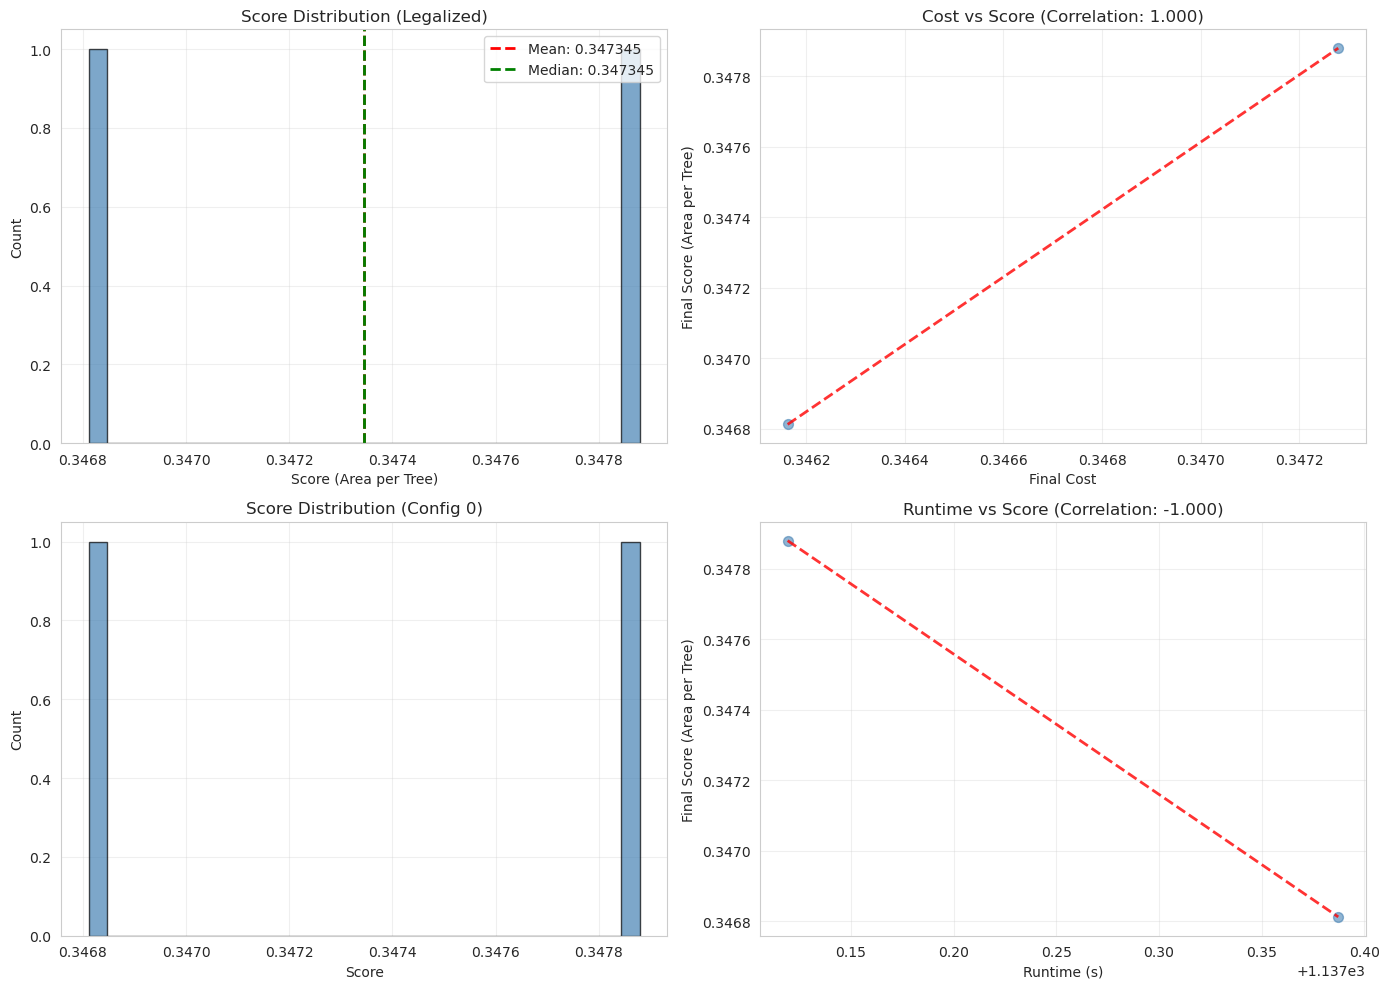

SCORE CORRELATIONS

Score vs Cost:    +1.0000
Score vs Runtime: -1.0000


In [50]:
if len(df) > 0 and 'score_final' in df.columns and not df['score_final'].isna().all():
    # Get score columns for different phenotypes
    score_cols = [col for col in df.columns if col.startswith('score_config_')]
    
    if len(score_cols) > 0:
        # Create figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        # 1. Score distribution histogram
        ax = axes[0]
        ax.hist(df['score_final'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(df['score_final'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["score_final"].mean():.6f}')
        ax.axvline(df['score_final'].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Median: {df["score_final"].median():.6f}')
        ax.set_xlabel('Score (Area per Tree)')
        ax.set_ylabel('Count')
        ax.set_title('Score Distribution (Legalized)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Cost vs Score scatter plot
        ax = axes[1]
        ax.scatter(df['cost_final'], df['score_final'], alpha=0.6, s=50, color='steelblue')
        
        # Add correlation
        corr = df[['cost_final', 'score_final']].corr().iloc[0, 1]
        ax.set_xlabel('Final Cost')
        ax.set_ylabel('Final Score (Area per Tree)')
        ax.set_title(f'Cost vs Score (Correlation: {corr:.3f})')
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        if len(df) > 1:
            z = np.polyfit(df['cost_final'], df['score_final'], 1)
            p = np.poly1d(z)
            x_line = np.linspace(df['cost_final'].min(), df['cost_final'].max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        # 3. Scores by phenotype (if multiple)
        ax = axes[2]
        if len(score_cols) > 1:
            # Create box plot for different phenotypes
            score_data = []
            labels = []
            for col in score_cols:
                config_id = col.split('_')[-1]
                score_data.append(df[col].dropna())
                labels.append(f'Config {config_id}')
            
            ax.boxplot(score_data, labels=labels, patch_artist=True,
                      boxprops=dict(facecolor='steelblue', alpha=0.7))
            ax.set_ylabel('Score (Area per Tree)')
            ax.set_title('Scores by phenotype')
            ax.grid(True, alpha=0.3, axis='y')
        else:
            # Single phenotype - show histogram
            ax.hist(df[score_cols[0]], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
            ax.set_xlabel('Score')
            ax.set_ylabel('Count')
            config_id = score_cols[0].split('_')[-1]
            ax.set_title(f'Score Distribution (Config {config_id})')
            ax.grid(True, alpha=0.3)
        
        # 4. Runtime vs Score
        ax = axes[3]
        if 'runtime' in df.columns and not df['runtime'].isna().all():
            ax.scatter(df['runtime'], df['score_final'], alpha=0.6, s=50, color='steelblue')
            
            # Add correlation
            corr_rt = df[['runtime', 'score_final']].corr().iloc[0, 1]
            ax.set_xlabel('Runtime (s)')
            ax.set_ylabel('Final Score (Area per Tree)')
            ax.set_title(f'Runtime vs Score (Correlation: {corr_rt:.3f})')
            ax.grid(True, alpha=0.3)
            
            # Add trend line
            if len(df) > 1:
                z = np.polyfit(df['runtime'], df['score_final'], 1)
                p = np.poly1d(z)
                x_line = np.linspace(df['runtime'].min(), df['runtime'].max(), 100)
                ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        else:
            ax.text(0.5, 0.5, 'No runtime data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Runtime vs Score')
        
        plt.tight_layout()
        plt.show()
        
        # Print correlation summary
        print("="*70)
        print("SCORE CORRELATIONS")
        print("="*70)
        print(f"\nScore vs Cost:    {df[['cost_final', 'score_final']].corr().iloc[0, 1]:+.4f}")
        if 'runtime' in df.columns and not df['runtime'].isna().all():
            print(f"Score vs Runtime: {df[['runtime', 'score_final']].corr().iloc[0, 1]:+.4f}")
    else:
        print("No per-phenotype score data available")
else:
    print("No score data available")

## Hyperparameter Impact Analysis

Analyze how each hyperparameter affects performance and runtime.

In [51]:
if len(df) > 0:
    # Identify modifier columns
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 
                      'score_final', 'score_final_std'] and 
                     not col.startswith('cost_gen_') and not col.startswith('score_trees_')]
    
    print(f"Analyzing {len(modifier_cols)} hyperparameters...\n")
    
    for modifier in modifier_cols:
        # Check if numeric or categorical
        is_numeric = pd.api.types.is_numeric_dtype(df[modifier])
        is_boolean = df[modifier].dtype == bool or set(df[modifier].unique()).issubset({True, False, np.nan})
        n_unique = df[modifier].nunique()
        
        print(f"\n{'='*70}")
        print(f"{modifier}")
        print(f"{'='*70}")
        print(f"Type: {'Boolean' if is_boolean else ('Numeric' if is_numeric else 'Categorical')}")
        print(f"Unique values: {n_unique}")
        if n_unique <= 10:
            print(f"Values: {sorted(df[modifier].unique())}")
        else:
            print(f"Range: [{df[modifier].min():.4g}, {df[modifier].max():.4g}]")
        
        # Correlation and p-value with final cost
        if is_numeric and not is_boolean and n_unique > 2:
            corr = df[[modifier, 'cost_final']].corr().iloc[0, 1]
            p_val, test_name = compute_pvalue(df, modifier, 'cost_final')
            print(f"Correlation with final cost: {corr:.3f} ({format_pvalue(p_val)})")
        elif n_unique >= 2:
            p_val, test_name = compute_pvalue(df, modifier, 'cost_final')
            print(f"Association with final cost: {format_pvalue(p_val)} [{test_name}]")
        
        # Correlation and p-value with final score
        if 'score_final' in df.columns and not df['score_final'].isna().all():
            if is_numeric and not is_boolean and n_unique > 2:
                corr_score = df[[modifier, 'score_final']].corr().iloc[0, 1]
                p_val_sc, test_name_sc = compute_pvalue(df, modifier, 'score_final')
                print(f"Correlation with final score: {corr_score:.3f} ({format_pvalue(p_val_sc)})")
            elif n_unique >= 2:
                p_val_sc, test_name_sc = compute_pvalue(df, modifier, 'score_final')
                print(f"Association with final score: {format_pvalue(p_val_sc)} [{test_name_sc}]")
        
        # Correlation and p-value with runtime
        if 'runtime' in df.columns and not df['runtime'].isna().all():
            if is_numeric and not is_boolean and n_unique > 2:
                corr_runtime = df[[modifier, 'runtime']].corr().iloc[0, 1]
                p_val_rt, test_name_rt = compute_pvalue(df, modifier, 'runtime')
                print(f"Correlation with runtime: {corr_runtime:.3f} ({format_pvalue(p_val_rt)})")
            elif n_unique >= 2:
                p_val_rt, test_name_rt = compute_pvalue(df, modifier, 'runtime')
                print(f"Association with runtime: {format_pvalue(p_val_rt)} [{test_name_rt}]")

Analyzing 4 hyperparameters...


n_generations
Type: Numeric
Unique values: 1
Values: [np.int64(201)]

crystal_offset
Type: Numeric
Unique values: 0
Values: [np.float64(nan)]

score_config_0
Type: Numeric
Unique values: 2
Values: [np.float64(0.34681164355121036), np.float64(0.34787917781518507)]
Association with final cost: p=N/A [insufficient_data]
Association with final score: p=N/A [insufficient_data]
Association with runtime: p=N/A [insufficient_data]

N_trees_to_do
Type: Numeric
Unique values: 1
Values: [np.float64(76.0)]


## Scatter Plots: Cost vs Hyperparameters

Visualize relationship between each hyperparameter and cost at different generations.

## Hyperparameter Impact on Scores

Analyze how each hyperparameter affects final scores.

In [52]:
# Identify modifier columns
modifier_cols = [col for col in df.columns if col not in 
                 ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 
                  'score_final', 'score_final_std'] and 
                 not col.startswith('cost_gen_') and not col.startswith('score_config_')]

# Analyze scores vs hyperparameters using unified function
analyze_outcome_vs_hyperparameters(df, 'score_final', 'Score', modifier_cols)

No hyperparameters with variation to analyze against score


In [53]:
if len(df) > 0:
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 
                      'score_final', 'score_final_std'] and 
                     not col.startswith('cost_gen_') and not col.startswith('score_config_')]
    
    cost_cols = [f'cost_gen_{gen}' for gen in generations_to_analyze if f'cost_gen_{gen}' in df.columns]
    
    if len(cost_cols) == 0:
        print("No cost columns found for specified generations!")
    
    # Filter out modifiers with no variation
    modifier_cols = [col for col in modifier_cols if df[col].nunique() > 1]
    
    for modifier in modifier_cols:
        # Create subplots for each generation
        n_plots = len(cost_cols)
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
        if n_plots == 1:
            axes = [axes]
        
        # Compute p-value for final cost to show in main title
        p_val_final, test_name = compute_pvalue(df, modifier, 'cost_final')
        fig.suptitle(f'Cost vs {modifier} — {format_pvalue(p_val_final)}', fontsize=14, fontweight='bold')
        
        for ax, cost_col in zip(axes, cost_cols):
            gen = int(cost_col.split('_')[-1])
            
            # Use helper function to create plot
            p_val = plot_modifier_vs_outcome(ax, df, modifier, cost_col, show_pval=True)
            
            # Update title to include generation info
            current_title = ax.get_title()
            ax.set_title(f'Gen {gen}: {current_title}', fontsize=10)
        
        plt.tight_layout()
        plt.show()

## Runtime Analysis

Analyze how each hyperparameter affects runtime.

In [54]:
# Identify modifier columns
modifier_cols = [col for col in df.columns if col not in 
                 ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 
                  'score_final', 'score_final_std'] and 
                 not col.startswith('cost_gen_') and not col.startswith('score_config_')]

# Analyze runtime vs hyperparameters using unified function
analyze_outcome_vs_hyperparameters(df, 'runtime', 'Runtime', modifier_cols)

No hyperparameters with variation to analyze against runtime


## Correlation Matrix

Show correlations between all numeric hyperparameters, runtime, and costs.

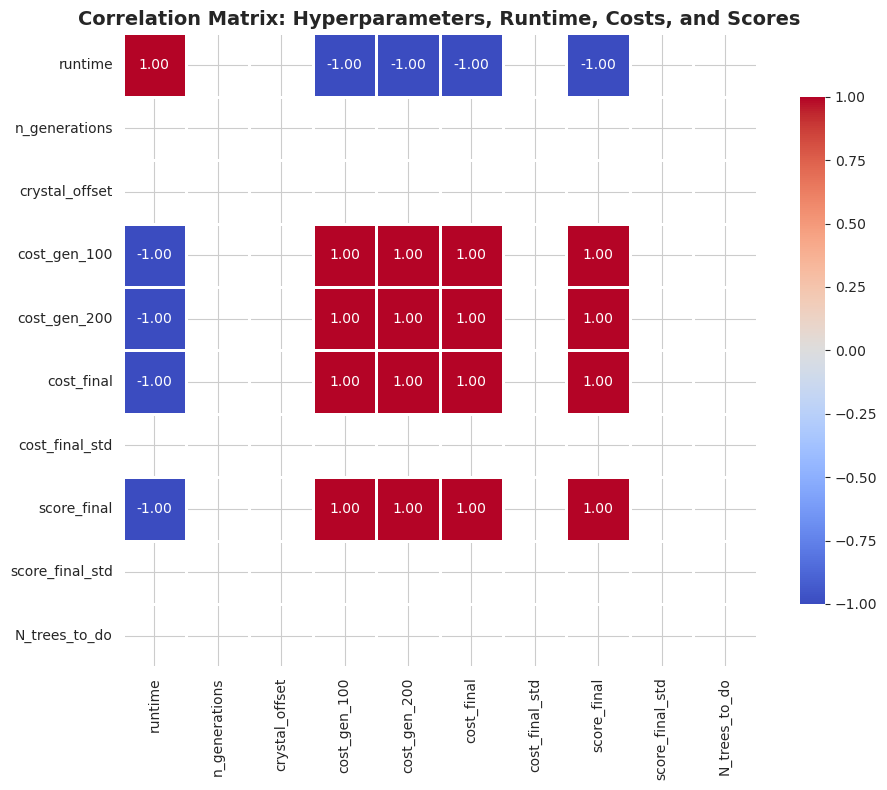


Strongest correlations with final cost:
runtime                       : -1.000
cost_gen_100                  : +1.000
cost_gen_200                  : +1.000
score_final                   : +1.000
n_generations                 : +nan
crystal_offset                : +nan
cost_final_std                : +nan
score_final_std               : +nan
N_trees_to_do                 : +nan

Strongest correlations with final score:
runtime                       : -1.000
cost_gen_100                  : +1.000
cost_gen_200                  : +1.000
cost_final                    : +1.000
n_generations                 : +nan
crystal_offset                : +nan
cost_final_std                : +nan
score_final_std               : +nan
N_trees_to_do                 : +nan


In [55]:
if len(df) > 0:
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove seed and per-generation/per-config columns
    numeric_cols = [col for col in numeric_cols if col not in ['seed'] and 
                    not col.startswith('cost_gen_') and not col.startswith('score_config_') or 
                    col in [f'cost_gen_{gen}' for gen in generations_to_analyze[:2]]]
    
    if len(numeric_cols) > 1:
        # Compute correlation matrix
        corr_matrix = df[numeric_cols].corr()
        
        # Plot heatmap
        plt.figure(figsize=(max(10, len(numeric_cols)*0.8), max(8, len(numeric_cols)*0.6)))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Correlation Matrix: Hyperparameters, Runtime, Costs, and Scores', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print strongest correlations with final cost
        if 'cost_final' in corr_matrix.columns:
            cost_corrs = corr_matrix['cost_final'].drop('cost_final').sort_values(key=abs, ascending=False)
            print("\nStrongest correlations with final cost:")
            print("="*50)
            for param, corr in cost_corrs.head(10).items():
                print(f"{param:30s}: {corr:+.3f}")
        
        # Print strongest correlations with final score
        if 'score_final' in corr_matrix.columns:
            score_corrs = corr_matrix['score_final'].drop('score_final').sort_values(key=abs, ascending=False)
            print("\nStrongest correlations with final score:")
            print("="*50)
            for param, corr in score_corrs.head(10).items():
                print(f"{param:30s}: {corr:+.3f}")

## Best Hyperparameter Settings

Identify the best hyperparameter combinations.

In [56]:
if len(df) > 0:
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 
                      'score_final', 'score_final_std', 'n_generations'] and 
                     not col.startswith('cost_gen_') and not col.startswith('score_config_')]
    
    print("="*70)
    print("TOP 10 BEST HYPERPARAMETER SETTINGS (by final cost)")
    print("="*70)
    
    best_df = df.nsmallest(10, 'cost_final')
    
    for rank, (idx, row) in enumerate(best_df.iterrows(), 1):
        score_str = f" | Score: {row.get('score_final', np.nan):.6f}" if 'score_final' in row and not pd.isna(row.get('score_final')) else ""
        print(f"\n#{rank} - Seed {row['seed']} - Cost: {row['cost_final']:.6f}{score_str}")
        print("-" * 70)
        for col in modifier_cols:
            print(f"  {col:30s}: {row[col]}")
        if 'runtime' in row and not pd.isna(row['runtime']):
            print(f"  {'Runtime':30s}: {row['runtime']:.1f}s")
    
    # Best by score if available
    if 'score_final' in df.columns and not df['score_final'].isna().all():
        print("\n" + "="*70)
        print("TOP 10 BEST HYPERPARAMETER SETTINGS (by final score)")
        print("="*70)
        
        best_score_df = df.nsmallest(10, 'score_final')
        
        for rank, (idx, row) in enumerate(best_score_df.iterrows(), 1):
            print(f"\n#{rank} - Seed {row['seed']} - Score: {row['score_final']:.6f} | Cost: {row['cost_final']:.6f}")
            print("-" * 70)
            for col in modifier_cols:
                print(f"  {col:30s}: {row[col]}")
            if 'runtime' in row and not pd.isna(row['runtime']):
                print(f"  {'Runtime':30s}: {row['runtime']:.1f}s")
    
    # Summary statistics for best vs worst
    print("\n" + "="*70)
    print("COMPARISON: Top 25% vs Bottom 25% (by cost)")
    print("="*70)
    
    n_quartile = max(1, len(df) // 4)
    top_25 = df.nsmallest(n_quartile, 'cost_final')
    bottom_25 = df.nlargest(n_quartile, 'cost_final')
    
    for col in modifier_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            top_mean = top_25[col].mean()
            bottom_mean = bottom_25[col].mean()
            diff = top_mean - bottom_mean
            print(f"\n{col}:")
            print(f"  Top 25% mean:    {top_mean:.4g}")
            print(f"  Bottom 25% mean: {bottom_mean:.4g}")
            print(f"  Difference:      {diff:+.4g}")
    
    # Summary by score if available
    if 'score_final' in df.columns and not df['score_final'].isna().all():
        print("\n" + "="*70)
        print("COMPARISON: Top 25% vs Bottom 25% (by score)")
        print("="*70)
        
        top_25_score = df.nsmallest(n_quartile, 'score_final')
        bottom_25_score = df.nlargest(n_quartile, 'score_final')
        
        for col in modifier_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                top_mean = top_25_score[col].mean()
                bottom_mean = bottom_25_score[col].mean()
                diff = top_mean - bottom_mean
                print(f"\n{col}:")
                print(f"  Top 25% mean:    {top_mean:.4g}")
                print(f"  Bottom 25% mean: {bottom_mean:.4g}")
                print(f"  Difference:      {diff:+.4g}")

TOP 10 BEST HYPERPARAMETER SETTINGS (by final cost)

#1 - Seed 6001 - Cost: 0.346162 | Score: 0.346812
----------------------------------------------------------------------
  crystal_offset                : nan
  N_trees_to_do                 : 76.0
  Runtime                       : 1137.4s

#2 - Seed 6000 - Cost: 0.347279 | Score: 0.347879
----------------------------------------------------------------------
  crystal_offset                : nan
  N_trees_to_do                 : 76.0
  Runtime                       : 1137.1s

TOP 10 BEST HYPERPARAMETER SETTINGS (by final score)

#1 - Seed 6001 - Score: 0.346812 | Cost: 0.346162
----------------------------------------------------------------------
  crystal_offset                : nan
  N_trees_to_do                 : 76.0
  Runtime                       : 1137.4s

#2 - Seed 6000 - Score: 0.347879 | Cost: 0.347279
----------------------------------------------------------------------
  crystal_offset                : nan
  N_trees_t

## Export Results

Save analysis results to CSV for further processing.

In [57]:
if len(df) > 0:
    output_file = f'../../results/many_ga/analysis_{runner_name}.csv'
    df.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    print(f"Shape: {df.shape}")

Results saved to: ../../results/many_ga/analysis_Baseline.csv
Shape: (2, 21)
